In [1]:
# fundemental modules
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
import time
import pprint
from tqdm.notebook import trange
import sys
import random as rndm
import board

# display visuals 
from utils import record_videos, show_videos

# deep learning modules
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, Flatten, TimeDistributed
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from keras.utils import plot_model
tf.random.set_seed(26)

2023-10-30 12:55:13.840145: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 12:55:14.129653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 12:55:14.129721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 12:55:14.131059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 12:55:14.245499: I tensorflow/core/platform/cpu_feature_g

In [2]:
#observations shape

class observation_shape:
        def __init__(self, obs, info, num_history):
            self.num_history = num_history
            self.observation_shape = obs.shape
            infos = np.array([info["speed"], info["action"][0]], dtype=np.float16)
            self.info_shape = infos.shape
            
        def info_edit(self, info):
            return np.array([info["speed"], info["action"][0]])
                            

        def reset(self):
            
            self.last_observations = [np.zeros(self.observation_shape)] * self.num_history
            self.last_info = [np.zeros(self.info_shape)] * self.num_history

        def update_input(self, obs, info):

            info  = self.info_edit(info)

            self.last_observations.append(obs)
            self.last_observations.pop(0)

            self.last_info.append(info)
            self.last_info.pop(0)

        def get_input(self):
            # obs_stack = np.stack(self.last_observations)
            # info_stack = np.stack(self.last_info)

            input = np.concatenate([self.last_observations[0].flatten(),
                                    self.last_observations[1].flatten(),
                                    self.last_info[0].flatten(),
                                    self.last_info[1].flatten()])


            return input




In [3]:
# PER

class ReplayBuffer(object):
    """
    * init the values
    * for DQN actions are discrete
    """
    def __init__(self, max_size, min_size, input_shape, n_actions, discrete=True):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.min_size = min_size
        self.discrete = discrete
        self.index = 0
        
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float16)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float16)
        dtype = np.int8 if self.discrete else np.float16
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float16)
        self.terminal_memory = np.zeros(self.mem_size)
        self.priorities = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):

        index = self.mem_cntr % self.mem_size                
        self.state_memory[index] = state
        self.new_state_memory[index] = state_

        #* store one hot encoding of actions, if appropriate
        if self.discrete:
            #* Create an zeros-array size of the number of actions
            actions = np.zeros(self.action_memory.shape[1])
            #* Make 1 the value of performed action
            actions[action] = 1.0
            #* Store in action memory
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action

        #* store reward and if it's terminal info 
        self.reward_memory[index] = reward
        #* we send inverse done info!!!
        self.terminal_memory[index] = 1 - done
        self.priorities[index] = max((self.priorities.max()), 1.0)
        self.mem_cntr +=1
        self.index = self.mem_cntr

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
        
    def get_importance(self, probabilities):
        importance = 1/(self.mem_cntr) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized

    def sample_buffer(self, batch_size, priority_scale=1.0):
        
        if self.mem_cntr >= self.mem_size:
            self.index = self.mem_size
            
        sample_size = batch_size
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = rndm.choices(range(self.index), k=sample_size, weights=sample_probs[:self.index])

        states = self.state_memory[sample_indices]
        actions = self.action_memory[sample_indices]
        rewards = self.reward_memory[sample_indices]
        states_ = self.new_state_memory[sample_indices]
        terminal = self.terminal_memory[sample_indices]

        # samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return states, actions, rewards, states_, terminal, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            error = abs(e) + offset
            clipped_error = np.minimum(error, 1.0)
            self.priorities[i] = clipped_error

In [4]:
#DDQN agent

class DDQNAgent:

    def __init__(self, alpha, gamma, epsilon, obs_shape,
                 batch_size, epsilon_dec, epsilon_end, mem_size, 
                 min_mem_size, learning_rate, replace_target):

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.min_mem_size = min_mem_size
        self.replace_target = replace_target
        self.obs_shape = obs_shape
        self.learning_rate = learning_rate

        self.discrete_action_space = np.array([-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,])
        
        self.n_actions = len(self.discrete_action_space)
        self.action_space = [i for i in range(self.n_actions)]

        self.memory = ReplayBuffer(max_size=self.mem_size, min_size=self.min_mem_size,input_shape=self.obs_shape,
                             n_actions=self.n_actions,discrete=True)
                        
        self.q_eval = self._make_model()
        self.q_target = self._make_model()      #we keep a target model which we update every K timesteps
        # self.q_eval.summary()
        # plot_model(self.q_eval, to_file='./model_ddqn.png')

        #* Custom tensorboard
        self.tensorboard = board.ModifiedTensorBoard(log_dir=f"logs/{board.MODEL_NAME}")

    def _make_model(self):
        
        model = Sequential()
        model.add( Dense(512, activation='relu', input_dim = self.obs_shape[0]) )
        model.add( Dense(512, activation='relu') )
        model.add( Dense( self.n_actions))
        model.compile(loss='mse',optimizer= Adam(learning_rate = self.learning_rate),metrics=["accuracy"]) # type: ignore
 
        return model

    def epsilon_decay(self):
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_end \
        else self.epsilon_end

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def update_network_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())
        
    def get_action(self, observation, deterministic=False):

        if np.random.random() > self.epsilon or deterministic: # type: ignore
    
            # observation = tf.convert_to_tensor(observation, dtype = tf.float16)
            observation = tf.expand_dims(observation, axis=0)

            qs_= self.q_eval.predict(observation, verbose=0) # type: ignore
            action_index = np.argmax(qs_)
            action = self.discrete_action_space[action_index]
        else:
            action_index = np.random.randint(0, self.n_actions)
            action = self.discrete_action_space[action_index]
        
        return action, action_index

    def train(self):

        if (self.memory.mem_cntr) < self.min_mem_size:
            return
        #* and ELSE:
        #* sample minibatch and get states vs..
        state, action, reward, new_state, done, sample_indices = \
                            self.memory.sample_buffer(self.batch_size)

        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)

        # state = tf.convert_to_tensor(state, dtype = tf.float16)
        # new_state = tf.convert_to_tensor(new_state, dtype = tf.float16)
        # reward = tf.convert_to_tensor(reward, dtype = tf.float16)
        # done = tf.convert_to_tensor(done)
        # action_indices = tf.convert_to_tensor(action_indices, dtype=np.int8)
        
        #* get the q values of current states by main network
        q_pred = self.q_eval.predict(state,verbose=0) # type: ignore

        #! for abs error
        target_old = np.array(q_pred)

        #* get the q values of next states by target network
        q_next = self.q_target.predict(new_state, verbose=0) # type: ignore #! target_val

        #* get the q values of next states by main network
        q_eval = self.q_eval.predict(new_state, verbose=0) # type: ignore #! target_next

        #* get the actions with highest q values
        max_actions = np.argmax(q_eval, axis=1)

        #* we will update this dont worry
        q_target = q_pred

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        #* new_q = reward + DISCOUNT * max_future_q
        q_target[batch_index, action_indices] = reward + \
                    self.gamma*q_next[batch_index, max_actions.astype(int)]*done

        #* error
        error = target_old[batch_index, action_indices]-q_target[batch_index, action_indices]
        self.memory.set_priorities(sample_indices, error)

        #* now we fit the main model (q_eval)
        _ = self.q_eval.fit(state, q_target, verbose = 0) # type: ignore

        #* If counter reaches set value, update target network with weights of main network
        #* it will update it at the very beginning also
        if self.memory.mem_cntr & self.replace_target == 0:
            self.update_network_parameters()
            print("Target Updated")

        gc.collect()
        K.clear_session()
        self.epsilon_decay()

    def save_model(self, episode):
        print("-----saving models------")
        self.q_eval.save_weights(f"weights/ddqn/q_net-{episode}.h5")
        # self.q_target.save_weights(self.network.checkpoint_file)

    def load_model(self):
        print("-----loading models------")
        self.q_eval.load_weights("q_net.h5")
        self.update_network_parameters()

In [5]:
# envirenment config

env = gym.make('racetrack-v0', render_mode = 'rgb_array')
env.configure({ # type: ignore
    'action': {'lateral': True,
            'longitudinal': False,
            'type': 'ContinuousAction'},
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 2,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h",
                     "heading", "long_off", "lat_off", "ang_off"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]}
    },
    'show_trajectories': True,
    'other_vehicles': 1,
    'duration': 100,
    'collision_reward': -5,
})

# prints env configs
#* obs is flattened to 1D array for nn

pprint.pprint(env.config) # type: ignore
(obs, info), done = env.reset(), False
# obs = np.array(obs.flatten())
print("Environment is setted up.")

{'action': {'lateral': True, 'longitudinal': False, 'type': 'ContinuousAction'},
 'action_reward': -0.3,
 'centering_position': [0.5, 0.5],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'duration': 100,
 'lane_centering_cost': 4,
 'lane_centering_reward': 1,
 'manual_control': False,
 'observation': {'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'cos_h',
                              'sin_h',
                              'heading',
                              'long_off',
                              'lat_off',
                              'ang_off'],
                 'features_range': {'vx': [-20, 20],
                                    'vy': [-20, 20],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'type': 'Kinematics',
                 'vehicles

/home/o/Documents/thesis/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/home/o/Documents/thesis/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


In [6]:
#observation config
proc = observation_shape(obs,info,2)
proc.reset()
input = proc.get_input()
# print(input.shape)

In [7]:
# agent config

#observation config
proc = observation_shape(obs,info,2)
proc.reset()
input = proc.get_input()
print(input.shape)

agent = DDQNAgent(alpha=0.001, gamma=0.9, epsilon=1.0, obs_shape=input.shape,
                  batch_size=256, epsilon_dec=0.999, epsilon_end=0.1, mem_size=100000,
                  min_mem_size=500, replace_target=1000, learning_rate=0.0003)

print("Agent is initialized.")

best_score = -100.0
score_history = []
episode_lens = []
avg_history = []
std_history = []


2023-10-30 12:55:16.525460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


(48,)


2023-10-30 12:55:16.638990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 12:55:16.639180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 12:55:16.640245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Agent is initialized.


In [8]:
# main loop
for episode in trange(1000, desc='Test episodes'):
        
        proc.reset()        
        (observation, info), done = env.reset(), False
        proc.update_input(observation, info)
        observation = proc.get_input()

        done_ = False
        episode_reward = 0
        episode_len = 0
        truncated = False

        while not done:
            action, action_index = agent.get_action(observation, deterministic=False)
            new_observation, reward, done, truncated, new_info = env.step(action=[action])
            proc.update_input(new_observation, info)
            new_observation = proc.get_input()
            
            if new_info["rewards"]["on_road_reward"] == False:
                 done = True
                 reward = -1.0

            episode_reward += reward # type: ignore
            episode_len +=1

            agent.remember(state=observation, action=action_index, done=done,
                            reward=reward, new_state=new_observation)
            agent.train()

            observation = new_observation
            
        episode_lens.append(episode_len)

        score_history.append(episode_reward)
        avg_score = np.mean(score_history)
        avg_history.append(avg_score)
        std_score = np.std(score_history)
        std_history.append(std_score)

        if avg_score > best_score and episode >50 :
            best_score = avg_score
            agent.save_model(episode)

        agent.tensorboard.update_stats(episode_rew = episode_reward, average_rew =avg_score, std_rew=std_score, epsilon=agent.epsilon)

        print('episode ', episode, 'score %.1f' % episode_reward, 'ep len', episode_len, 
              'avg score %.1f' % avg_score, 'std score %.1f' % std_score)
        
        time.sleep(1)
env.close()


Test episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-10-30 12:55:17.709693: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


episode  0 score 10.4 ep len 14 avg score 10.4 std score 0.0
episode  1 score 8.6 ep len 12 avg score 9.5 std score 0.9
episode  2 score 1.5 ep len 4 avg score 6.9 std score 3.8
episode  3 score 7.0 ep len 10 avg score 6.9 std score 3.3
episode  4 score 8.2 ep len 11 avg score 7.2 std score 3.0
episode  5 score 7.7 ep len 11 avg score 7.3 std score 2.8
episode  6 score 10.2 ep len 14 avg score 7.7 std score 2.7
episode  7 score 8.0 ep len 11 avg score 7.7 std score 2.6
episode  8 score 4.3 ep len 7 avg score 7.3 std score 2.6
episode  9 score 3.2 ep len 6 avg score 6.9 std score 2.8
episode  10 score 10.5 ep len 14 avg score 7.2 std score 2.9
episode  11 score 10.5 ep len 14 avg score 7.5 std score 2.9
episode  12 score 10.5 ep len 14 avg score 7.7 std score 2.9
episode  13 score 6.8 ep len 10 avg score 7.7 std score 2.8
episode  14 score 20.2 ep len 25 avg score 8.5 std score 4.1
episode  15 score 6.2 ep len 9 avg score 8.4 std score 4.0
episode  16 score 19.4 ep len 23 avg score 9.0 

2023-10-30 12:56:01.383251: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4300435ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 12:56:01.383266: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-30 12:56:01.388445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 12:56:02.643526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-10-30 12:56:02.704240: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


episode  38 score 11.2 ep len 15 avg score 9.7 std score 5.0
episode  39 score 7.8 ep len 11 avg score 9.6 std score 5.0
episode  40 score 12.2 ep len 16 avg score 9.7 std score 4.9
episode  41 score 15.4 ep len 20 avg score 9.8 std score 4.9
episode  42 score 5.9 ep len 9 avg score 9.8 std score 4.9
episode  43 score 8.2 ep len 11 avg score 9.7 std score 4.9
episode  44 score 4.3 ep len 7 avg score 9.6 std score 4.9
episode  45 score 11.2 ep len 15 avg score 9.6 std score 4.8
episode  46 score 3.3 ep len 6 avg score 9.5 std score 4.9
episode  47 score 4.3 ep len 7 avg score 9.4 std score 4.9
episode  48 score 6.2 ep len 9 avg score 9.3 std score 4.8
episode  49 score 15.4 ep len 20 avg score 9.4 std score 4.9
episode  50 score 3.4 ep len 6 avg score 9.3 std score 4.9
-----saving models------
episode  51 score 17.8 ep len 22 avg score 9.5 std score 5.0
-----saving models------
episode  52 score 14.9 ep len 19 avg score 9.6 std score 5.0
-----saving models------
episode  53 score 19.1 e

KeyboardInterrupt: 

In [ ]:
agent.save_model(704)

-----saving models------


In [10]:
np.save("score_history_1000", np.array(score_history))
np.save("avg_history_1000", np.array(avg_history))
np.save("std_history_1000", np.array(std_history))
np.save("episode_lens_1000", np.array(episode_lens))

29.18129408055823
29.180735688496398


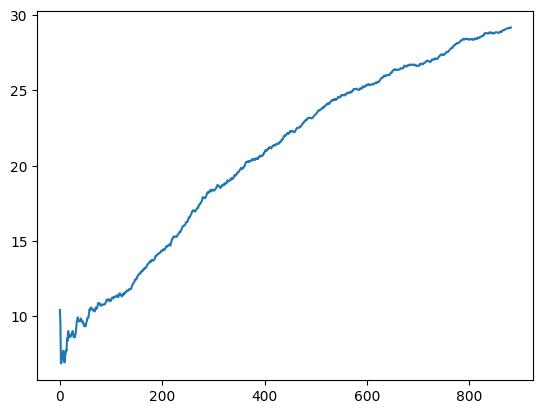

In [11]:
print(best_score)
print(avg_score)
# for i in range(len(score_history)):
#     score_history[i] += 9
plt.plot(avg_history)
plt.show()

In [15]:
# #Evaluating
# agent.load_model()
# env = gym.make("racetrack-v0", render_mode='rgb_array')
# env.configure({ # type: ignore
#     'action': {'lateral': True,
#             'longitudinal': False,
#             'target_speeds': [0, 3],
#             'type': 'ContinuousAction'},
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 2,
#         "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h",
#                      "heading", "long_off", "lat_off", "ang_off"],
#     },
#     'show_trajectories': True,
#     "other_vehicles": 1

# })
env = record_videos(env)

for episode in trange(50, desc='Test episodes'):
        
        proc.reset()        
        (observation, info), done = env.reset(), False
        proc.update_input(observation, info)
        observation = proc.get_input()

        while not done:
            action, action_index = agent.get_action(observation, deterministic=True)
            new_observation, reward, done, truncated, new_info = env.step(action=[action])
            proc.update_input(new_observation, info)
            new_observation = proc.get_input()

            if new_info["rewards"]["on_road_reward"] == False:
                 done = True

            observation = new_observation


/home/o/Documents/thesis/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test episodes:   0%|          | 0/50 [00:00<?, ?it/s]

Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-0.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-0.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-1.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-1.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-2.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-2.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-3.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-3.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-4.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-9.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-9.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-9.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-9.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-5.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-10.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-10.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-10.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-10.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-6.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-11.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-11.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-11.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-11.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-7.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-12.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-12.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-12.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-12.mp4
Moviepy - Building video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4.
Moviepy - Writing video /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/o/Documents/thesis/highway/1000_ep_tuned_tb/videos/trainings/ddqn/rl-video-episode-8.mp4


In [ ]:
show_videos()